<a href="https://colab.research.google.com/github/smitha13798/3dcv-students_Group4/blob/main/3_0_tl_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 4

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [2]:
print("Is MPS available?    ",torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
print("MPS activated:       ",torch.backends.mps.is_built()) #MPS is activated

Is MPS available?     False
MPS activated:        False


## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [3]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch

    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()

    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for i, (data, target) in enumerate(train_loader):

        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()

        # TODO: run the network
        output = model(data)

        # TODO: compute negative log likelihood loss
        loss = F.nll_loss(output, target)

        # TODO: do backpropagation
        loss.backward()

        # TODO: optimize
        optimizer.step()

        # TODO: print current loss for every nth ("log_interval"th) iteration
        if i % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(data), len(train_loader.dataset),
                100. * i / len(train_loader), loss.item()))


We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [4]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics

    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)

    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0

    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()

            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()

            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()

            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10

                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))

                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0

                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)

                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())

                plotted += 1
                img_idx += 1

    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [5]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network

    Five fully connected layers with sigmoid non-linearity

    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()

        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        # Initialize network layers
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)


    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(-1, 784)

        # TODO: run network layers
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = F.sigmoid(self.fc4(x))

        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(self.fc5(x), dim=1)

        return output

In [6]:
class FCNet2(nn.Module):
    def __init__(self):
        super(FCNet2, self).__init__()

        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)

    def forward(self, x):

        x = x.view(-1, 784) # reshaping

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        output = F.log_softmax(self.fc5(x), dim=1)
        # pass
        return output

In [7]:
class FCNet3(nn.Module):
    def __init__(self):
        super(FCNet3, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.bn1 = nn.BatchNorm1d(200)  # normalisation
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.bn2 = nn.BatchNorm1d(60)   # normalisation
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)

    def forward(self, x):

        x = x.view(-1, 784) # reshaping

        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.bn2(self.fc3(x)))
        x = F.relu(self.fc4(x))

        output = F.log_softmax(self.fc5(x), dim=1)
        # pass
        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [8]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network

    Two convolutional layers and two fully connected layers

    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()

        # TODO: initialize network layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        # TODO: run convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))


        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(-1, 64 * 12 * 12)

        # TODO: run fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)

        return output

In [9]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)  # normalisation
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.bn2 = nn.BatchNorm1d(128)  # normalisation
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv2(x))

        x = x.view(-1, 64 * 6 * 6) # reshaping
        x = F.relu(self.bn2(self.fc1(x)))
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        # pass
        return output

In [10]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):

        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))

        x = x.view(-1, 64 * 6 * 6)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        # pass
        return output

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305907
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.353167
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.123213
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.299975
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.251720
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.109103
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.168380
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.057661
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.058299
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.188259

Test set: Average loss: 0.1281, Accuracy: 9629/10000 (96.29%)



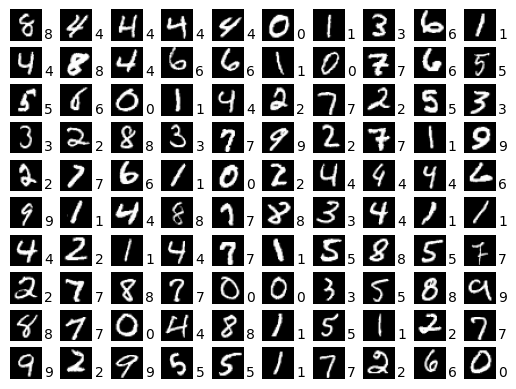

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.096171
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.007566
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.089863
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.098079
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.092060
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.026942
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.211415
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.240386
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.038642
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.063101

Test set: Average loss: 0.0910, Accuracy: 9730/10000 (97.30%)



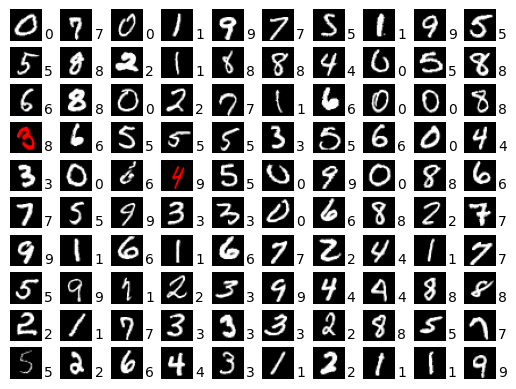

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.077208
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.036542
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.029776
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.006074
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.014470
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.049571
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.137212
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.003124
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.029071
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.020668

Test set: Average loss: 0.0863, Accuracy: 9777/10000 (97.77%)



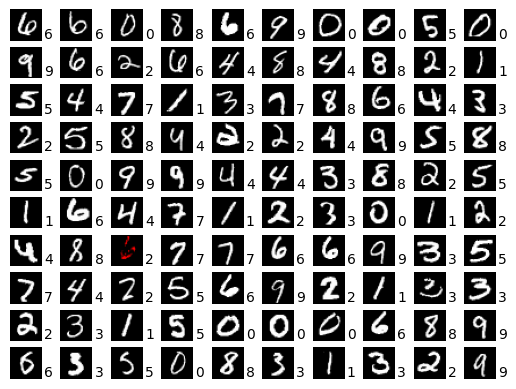

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.016175
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.005852
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.027385
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.012107
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.061648
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.026003
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.089850
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.018027
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.048484
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.034420

Test set: Average loss: 0.0816, Accuracy: 9800/10000 (98.00%)



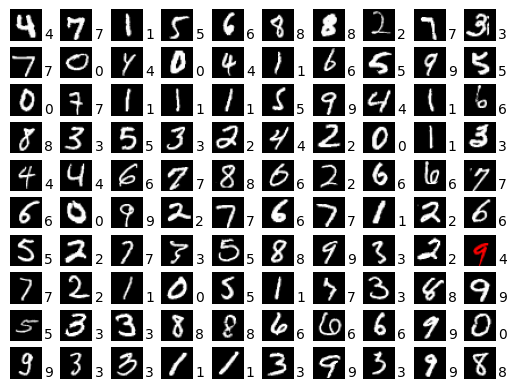

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.018933
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.040544
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.008035
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.035448
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.000754
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.010276
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.006835
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.012563
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.001948
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.004987

Test set: Average loss: 0.0827, Accuracy: 9807/10000 (98.07%)



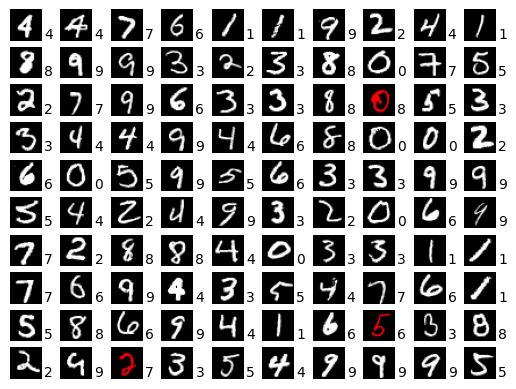

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.001950
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.001218
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.000930
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.003556
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.005062
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.002607
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.003778
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.024786
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.000685
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.033894

Test set: Average loss: 0.0866, Accuracy: 9817/10000 (98.17%)



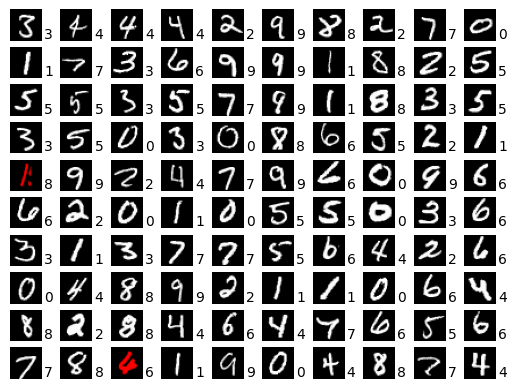

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.006667
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.000706
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.005946
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.003791
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.000122
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.006762
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.000385
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.002504
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.000056
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.007231

Test set: Average loss: 0.0866, Accuracy: 9830/10000 (98.30%)



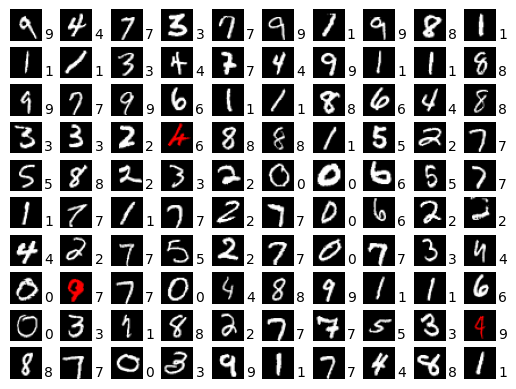

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000475
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.004498
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.003998
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.000845
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.000745
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.002162
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.000648
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.000290
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.007628
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.000187

Test set: Average loss: 0.0864, Accuracy: 9824/10000 (98.24%)



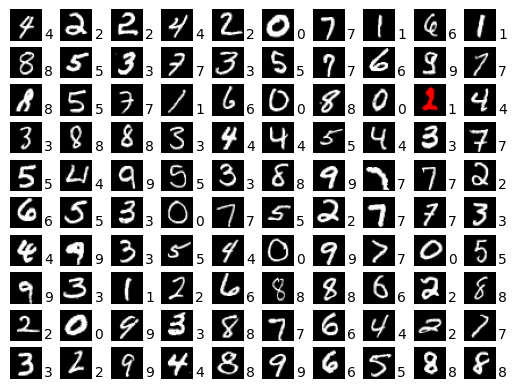

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000060
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.005467
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.000174
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.001563
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.001072
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.017503
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.000962
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.000764
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.002755
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.005455

Test set: Average loss: 0.0892, Accuracy: 9825/10000 (98.25%)



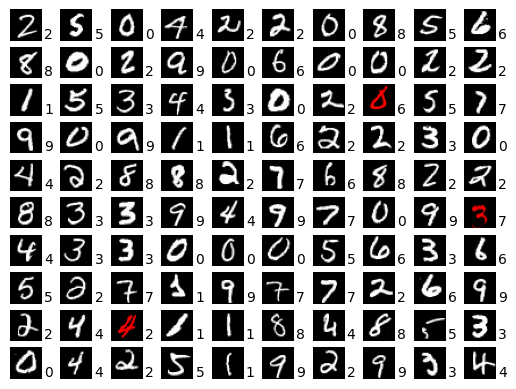

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.000607
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.002683
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.000595
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.000053
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.001357
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.000573
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.000810
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.000438
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.018594
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.000292

Test set: Average loss: 0.0902, Accuracy: 9831/10000 (98.31%)



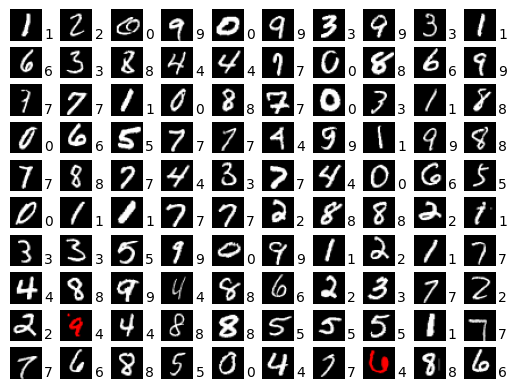

In [12]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)

    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()


    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")